In [1]:
import re
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Identifying which H-T/T-H motifs are TnG Repeats

### Loading ChIP-seq peaks

In [2]:
# Load FoxP3 ChIP-seq peak sequences
foxp3_peak_sequences = pd.read_csv('figure3_files/foxp3_chipseq_peak_sequences.csv')

In [3]:
foxp3_peak_sequences.head()

,chr,start,end,sequence
0,1,3241741,3241906,GTATCTGTTGAGGCCTGTTTTGTGACCAATTATATGGTCAATTTTG...
1,1,3348853,3349060,AAAATTCCAACTCAATTCTTCAATGAATTAGAAGGAGCAATTTGCA...
2,1,3768258,3768453,TATTTGTGACTATTGAGAAGGGTGTTGTTTCCCTAATTTCTTTCTC...
3,1,4084204,4084359,TATGTGTCGGGAGGAATTTCTTTTCTGGTCCAGTCTATTTGGAGTT...
4,1,4486722,4486910,TGGAACAACATTATAAACTAACCAGTACCCCGGAGCTCTTGACTCT...


### Example of building reg-ex motifs and searching for them

In [4]:
# Top 10 enriched motif sequences in forward and reverse-complement orientation
motifs_forward = ['NNAAACA', 'NAAACAN', 'NNCAACA', 'NCAACAN', 'ATGCGNN', 'GATGCNN', 'ATGCANN', 'AATGCNN', 'NATGCAN', 'ATGCNNC']
motifs_reverse = ['TGTTTNN', 'NTGTTTN', 'TGTTGNN', 'NTGTTGN', 'NNCGCAT', 'NNGCATC', 'NNTGCAT', 'NNGCATT', 'NTGCATN', 'GNNGCAT']

# Pairwise motif combinations for each orientation:
motif_combos_TH = [(f1, f2) for f1 in motifs_forward for f2 in motifs_forward]
motif_combos_HT = [(r1, r2) for r1 in motifs_reverse for r2 in motifs_reverse]

In [5]:
# Convert peak DataFrame into a list of tuples: (chrom, start, end, sequence)
chipseq_sequences = list(foxp3_peak_sequences.itertuples(index=False, name=None))

def generate_regex_motifs(motif_pairs):
    """
    Convert motif pairs into regex patterns with a fixed 4bp spacer between motifs.
    """
    return [
        f"{f.replace('N', '[ATGC]')}[ATGC]{{4}}{r.replace('N', '[ATGC]')}"
        for f, r in motif_pairs
    ]

def build_motif_regex_dict():
    """
    Generate a dictionary of regex motif patterns by orientation:
    """
    return {
        'TH': {i: p for i, p in enumerate(generate_regex_motifs(motif_combos_TH))},
        'HT': {i: p for i, p in enumerate(generate_regex_motifs(motif_combos_HT))}
    }

# Build all regex motif patterns
motif_regex_by_orientation = build_motif_regex_dict()

In [6]:
# Display 3 example regex motifs from each orientation
for orientation, motifs in motif_regex_by_orientation.items():
    print(f"Examples from orientation '{orientation}':")
    for i in list(motifs.keys())[:3]:
        print(f"  {i}: {motifs[i]}")
    print()

Examples from orientation 'TH':
  0: [ATGC][ATGC]AAACA[ATGC]{4}[ATGC][ATGC]AAACA
  1: [ATGC][ATGC]AAACA[ATGC]{4}[ATGC]AAACA[ATGC]
  2: [ATGC][ATGC]AAACA[ATGC]{4}[ATGC][ATGC]CAACA

Examples from orientation 'HT':
  0: TGTTT[ATGC][ATGC][ATGC]{4}TGTTT[ATGC][ATGC]
  1: TGTTT[ATGC][ATGC][ATGC]{4}[ATGC]TGTTT[ATGC]
  2: TGTTT[ATGC][ATGC][ATGC]{4}TGTTG[ATGC][ATGC]



In [7]:
def match_example_pattern(sequences, pattern_label, pattern):
    matches_list = []
    regex = re.compile(pattern)

    for chrom, peak_start, peak_end, sequence in sequences:
        if sequence == "Sequence not found" or pd.isna(sequence):
            continue
        for match in regex.finditer(sequence):
            match_start = peak_start + match.start() - 1 # minus 1 for indexing
            match_end = peak_start + match.end()
            matched_seq = match.group()
            matches_list.append((chrom, match_start, match_end, matched_seq))

    df_matches = pd.DataFrame(matches_list, columns=['chr', 'start', 'end', 'sequence'])
    return df_matches

# Example usage
example_label = "Example_Motif"
example_pattern = "[ATGC]{2}AAACA[ATGC]{4}[ATGC]{2}AAACA"
df_example_matches = match_example_pattern(chipseq_sequences, example_label, example_pattern)

# Print top 5 matches
df_example_matches.head()

,chr,start,end,sequence
0,1,7396996,7397015,CAAAACAAAAAGCAAACA
1,1,7397126,7397145,ACAAACAAAAACCAAACA
2,1,33883650,33883669,AAAAACAAAAACAAAACA
3,1,36470693,36470712,AAAAACAAACAAAAAACA
4,1,36470711,36470730,AAAAACAAAAACAAAACA


### Load all HT and TH in FoxP3 and FoxP1 then search for TnG overlap

In [8]:
# FoxP3 motif pair loci (from TH and HT orientations)
loci_foxp3_th = pd.read_csv("figure4_files/foxp3_chipseq_th_loci.csv")
loci_foxp3_ht = pd.read_csv("figure4_files/foxp3_chipseq_ht_loci.csv")

# FoxP1 motif pair loci (from TH and HT orientations)
loci_foxp1_th = pd.read_csv("figure4_files/foxp1_chipseq_th_loci.csv")
loci_foxp1_ht = pd.read_csv("figure4_files/foxp1_chipseq_ht_loci.csv")

In [9]:
def analyze_group_overlap(valid_groups, motif_pair_df, tng_df):
    """
    Merges grouped motif-pair loci, checks for overlaps with TnG repeat loci, and computes overlap fraction.
    """
    def merge_intervals(df):
        merged = []
        current_chr = None
        current_region = None
        for _, row in df.iterrows():
            if row['chr'] != current_chr:
                if current_region:
                    merged.append(current_region)
                current_chr = row['chr']
                current_region = [row['chr'], row['start'], row['end']]
            elif row['start'] > current_region[2]:
                merged.append(current_region)
                current_region = [row['chr'], row['start'], row['end']]
            else:
                current_region[2] = max(current_region[2], row['end'])
        if current_region:
            merged.append(current_region)
        return pd.DataFrame(merged, columns=['chr', 'start', 'end'])

    def check_partial_overlap(row, chip_df):
        return ((chip_df['chr'] == row['chr']) & 
                (chip_df['TnG_start'] <= row['end']) & 
                (chip_df['TnG_end'] >= row['start'])).any()

    filtered = motif_pair_df[motif_pair_df["group"].isin(valid_groups)].copy()
    filtered_sorted = filtered.sort_values(by=['chr', 'start']).reset_index(drop=True)
    merged = filtered_sorted.groupby('chr', group_keys=False).apply(merge_intervals).reset_index(drop=True)

    merged['overlaps'] = merged.apply(
        lambda row: 1 if check_partial_overlap(row, tng_df) else 0, axis=1
    )

    overlap_fraction = merged['overlaps'].sum() / len(merged)
    return merged, overlap_fraction

In [10]:
# Load genomic locations of TnG repeats from ChIP-seq experiments
foxp1_chipseq_tng_loci = pd.read_csv("figure4_files/foxp1_chipseq_tng_loci.csv")
foxp3_chipseq_tng_loci = pd.read_csv("figure4_files/foxp3_chipseq_tng_loci.csv")

# FoxP3: Head-to-Tail (HT)
valid_groups_ht_foxp3 = {1,2,3,4,10,11,12,13,14,21,22,23,24,31,32,34} #Boxes in Fig 3B FoxP3 HT that are shaded
df_result, _ = analyze_group_overlap(valid_groups_ht_foxp3, loci_foxp3_ht, foxp3_chipseq_tng_loci)
percent_tng_foxp3_ht = len(df_result[df_result['overlaps'] == 1]) / len(df_result) * 100

# FoxP3: Tail-to-Head (TH)
valid_groups_th_foxp3 = {1,2,3,4,11,12,13,14,21,22,23,31,32,33,34,56,91} #Boxes in Fig 3B FoxP3 TT that are shaded
df_result, _ = analyze_group_overlap(valid_groups_th_foxp3, loci_foxp3_th, foxp3_chipseq_tng_loci)
percent_tng_foxp3_th = len(df_result[df_result['overlaps'] == 1]) / len(df_result) * 100

# FoxP1: Head-to-Tail (HT)
valid_groups_ht_foxp1 = {1,2,3,4,11,12,13,14,21,22,23,24,31,32,33,34} #Boxes in Fig 3B FoxP1 HT that are shaded
df_result, _ = analyze_group_overlap(valid_groups_ht_foxp1, loci_foxp1_ht, foxp1_chipseq_tng_loci)
percent_tng_foxp1_ht = len(df_result[df_result['overlaps'] == 1]) / len(df_result) * 100

# FoxP1: Tail-to-Head (TH)
valid_groups_th_foxp1 = {1,2,3,4,11,12,13,14,21,22,23,24,31,32,33,34} #Boxes in Fig 3B FoxP1 TT that are shaded
df_result, _ = analyze_group_overlap(valid_groups_th_foxp1, loci_foxp1_th, foxp1_chipseq_tng_loci)
percent_tng_foxp1_th = len(df_result[df_result['overlaps'] == 1]) / len(df_result) * 100

# Print summary (ignore warnings)
print(f"FoxP3 Head-to-Tail overlap with TnG repeats: {percent_tng_foxp3_ht:.2f}%")
print(f"FoxP3 Tail-to-Head overlap with TnG repeats: {percent_tng_foxp3_th:.2f}%")
print(f"FoxP1 Head-to-Tail overlap with TnG repeats: {percent_tng_foxp1_ht:.2f}%")
print(f"FoxP1 Tail-to-Head overlap with TnG repeats: {percent_tng_foxp1_th:.2f}%")

/tmp/ipykernel_28019/3182133243.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = filtered_sorted.groupby('chr', group_keys=False).apply(merge_intervals).reset_index(drop=True)
/tmp/ipykernel_28019/3182133243.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged = filtered_sorted.groupby('chr', group_keys=False).apply(merge_intervals).reset_index(drop=True)
/tmp/ipykernel_28019/3182133243.

FoxP3 Head-to-Tail overlap with TnG repeats: 80.38%
FoxP3 Tail-to-Head overlap with TnG repeats: 78.63%
FoxP1 Head-to-Tail overlap with TnG repeats: 84.24%
FoxP1 Tail-to-Head overlap with TnG repeats: 84.74%


### Plot overlap comparison

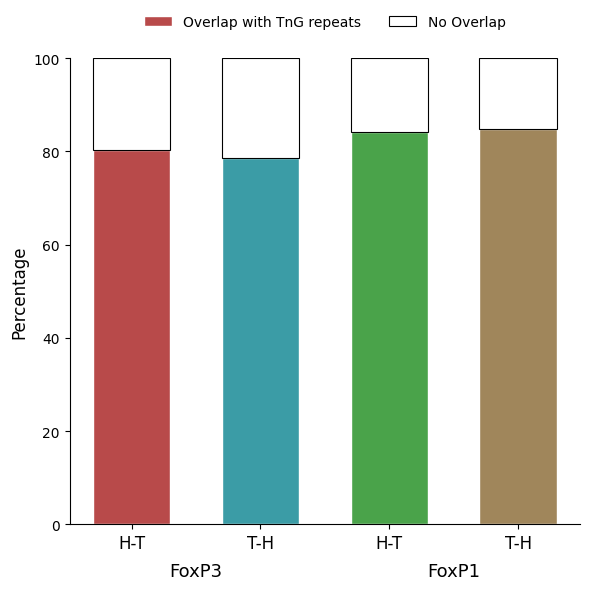

In [11]:
# Plot overlap percentages (from previous calculations)
overlap = [
    percent_tng_foxp3_ht,  # FoxP3 Head-to-Tail
    percent_tng_foxp3_th,  # FoxP3 Tail-to-Head
    percent_tng_foxp1_ht,  # FoxP1 Head-to-Tail
    percent_tng_foxp1_th   # FoxP1 Tail-to-Head
]

# Complement (non-overlapping regions)
non_overlap = [100 - val for val in overlap]

# Bar x positions
labels = ['H-T', 'T-H', 'H-T', 'T-H']
x = np.arange(len(labels))
width = 0.6

# Bar colors
overlap_colors = ['#b84a4a', '#3b9ca6', '#4aa34a', '#a0865b']  # distinct solid fill
non_overlap_color = 'white'

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot overlapping segments
bars_overlap = ax.bar(
    x, overlap, width,
    color=overlap_colors,
    edgecolor='white',
    label='Overlap with TnG repeats'
)

# Plot non-overlapping segments
bars_non_overlap = ax.bar(
    x, non_overlap, width,
    bottom=overlap,
    color=non_overlap_color,
    edgecolor='black',
    linewidth=0.8,
    label='No Overlap'
)

# Axis labels and ticks
ax.set_ylabel('Percentage', fontsize=12)
ax.set_ylim(0, 100)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)

# Group labels below the bars
ax.text(0.5, -10, 'FoxP3', ha='center', va='center', fontsize=13, transform=ax.transData)
ax.text(2.5, -10, 'FoxP1', ha='center', va='center', fontsize=13, transform=ax.transData)

# Legend settings
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    frameon=False,
    fontsize=10,
    ncol=2
)

# Cleanup aesthetics
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()